In [39]:
LOCAL_ENV = False
USE_WANDB = True

In [2]:
from pathlib import Path
import shutil
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from numpy.random import default_rng

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional.classification import f1_score
from torchmetrics import Dice

import pytorch_lightning as pl
from torchvision.models import vgg19, VGG19_Weights, vgg11, VGG11_Weights

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import wandb

In [3]:
if not LOCAL_ENV:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    my_secret = user_secrets.get_secret("wandb_key")
else:
    my_secret = None

In [40]:
if USE_WANDB:
    wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
np.random.seed(42)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data preparation

In [6]:
if LOCAL_ENV:
    DS_DIR = Path('/home/viktor/PythonProjects/data/airbus-ship-detection/')
    MODELS_DIR = Path('models/')
    WORK_DIR = Path('output/')
else:
    DS_DIR = Path('../input/airbus-ship-detection/')
    MODELS_DIR = Path('../input/models/')
    WORK_DIR = Path('/kaggle/working/')

In [7]:
train_df = pd.read_csv(DS_DIR/'train_ship_segmentations_v2.csv')
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
transform = A.Compose(
    [
        A.Flip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    ]
)

In [9]:
def get_mask(img, metadata, img_id):
    h, w = img.shape[:2]
    mask = np.zeros(img.shape[:2]).astype(int)
    encoded_pixels_list = list(metadata[metadata['ImageId'] == img_id]['EncodedPixels'])
    for encoded_pixels in encoded_pixels_list:
        if isinstance(encoded_pixels, float) and np.isnan(encoded_pixels):
            continue
        encoded_pixels = list(map(int, encoded_pixels.split(' ')))
        for i in range(int(len(encoded_pixels)/2)):
            ran = np.arange(encoded_pixels[i*2+1])
            ran = ran + encoded_pixels[i*2]
            for num in ran:
                num = num-1
                col = num//h
                row = num - h*col
                mask[row][col] = 1
    return mask

In [10]:
class ImagesDataset(Dataset):
    def __init__(self, images_dir, metadata, get_mask, transform=None):
        self.images_dir = images_dir
        self.metadata = metadata
        self.image_ids = metadata['ImageId'].unique()
        self.get_mask = get_mask
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        
        img = cv2.imread(str(self.images_dir/img_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = self.get_mask(img, self.metadata, img_id)
        
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        return img, mask

In [11]:
unique_ids = train_df['ImageId'].unique()
np.random.shuffle(unique_ids)
train_ids = unique_ids[:int(len(unique_ids) * 0.6)]
val_ids = unique_ids[int(len(unique_ids) * 0.6):int(len(unique_ids) * 0.8)]
test_ids = unique_ids[int(len(unique_ids) * 0.8):len(unique_ids) * 1]

In [12]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [13]:
train_metadata = train_df[train_df['ImageId'].isin(train_ids)].reset_index(drop=True)
val_metadata = train_df[train_df['ImageId'].isin(val_ids)].reset_index(drop=True)
test_metadata = train_df[train_df['ImageId'].isin(test_ids)].reset_index(drop=True)

In [14]:
train_ds = ImagesDataset(DS_DIR/'train_v2', train_metadata, get_mask, transform)
val_ds = ImagesDataset(DS_DIR/'train_v2', val_metadata, get_mask)
test_ds = ImagesDataset(DS_DIR/'train_v2', test_metadata, get_mask)

In [15]:
def show_ds_example(ds, idx):
    img, mask = ds[idx]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
    axs[0].imshow(img)
    axs[1].imshow(mask, cmap='gray')
    plt.show()

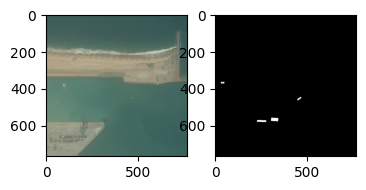

In [16]:
show_ds_example(train_ds, 2)

In [17]:
def input_transform():
    transform = A.Compose(
        [
#             A.Resize(height=224, width=224),
            A.Resize(height=384, width=384),
#             A.Resize(height=576, width=576),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

            ToTensorV2(),
        ]
    )
    
    return transform

In [18]:
def collate(batch):
    imgs, masks = [], []
    for img, mask in batch:
        augs = input_transform()(image=img, mask=mask)
        imgs.append(augs['image'][None])
        masks.append(augs['mask'][None])
    
    imgs = torch.cat(imgs).float()
    masks = torch.cat(masks).long()

    return imgs, masks

In [19]:
BATCH_SIZE = 10

In [20]:
train_dl = DataLoader(
    dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collate, num_workers=3
    )
val_dl = DataLoader(  
    dataset=val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=3
    )
test_dl = DataLoader(  
    dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=3
    )

In [21]:
# torch.cuda.empty_cache()

In [22]:
# test_model_run(model)

In [23]:
len(train_dl)

11553

[[-1.0904187  -1.1075435  -1.004795   ... -1.0561693  -1.1246682
  -1.0390445 ]
 [-1.1246682  -1.0561693  -0.9876702  ... -1.0390445  -1.1075435
  -1.1075435 ]
 [-1.2274168  -1.1760424  -1.0219197  ... -1.0904187  -1.141793
  -1.0732939 ]
 ...
 [-0.78217316 -0.8506722  -1.0561693  ... -1.0904187  -0.9876702
  -1.141793  ]
 [-0.8164227  -0.6965494  -0.86779696 ... -1.1075435  -1.0732939
  -0.90204644]
 [-1.1246682  -1.004795   -1.004795   ... -1.141793   -1.2274168
  -1.0219197 ]]


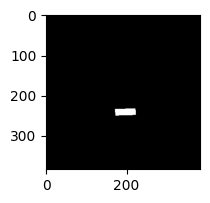

In [24]:
def show_dl_example(dl):
    imgs, masks = next(iter(dl))
    img, mask = imgs[0].numpy(), masks[0].numpy()
    
    print(img[0])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    ax.imshow(mask, cmap='gray')
    plt.show()

show_dl_example(val_dl)

# Model

In [25]:
def up_conv(in_channels, out_channels):
    mod = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )
    return mod

def conv(in_channels, out_channels):
    mod = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
    )
    return mod

In [26]:
# encoder_layers = vgg11(weights=VGG11_Weights.DEFAULT, progress=True).features
# encoder_layers

In [27]:
# realization of the paper: https://arxiv.org/pdf/1801.05746.pdf
class UNetVGG11Model(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        if pretrained:
            weights = VGG11_Weights.DEFAULT
        else:
            weights = None
        encoder_layers = vgg11(weights=weights, progress=True).features
        
        self.block1 = nn.Sequential(*encoder_layers[:2])
        self.block2 = nn.Sequential(*encoder_layers[2:5])
        self.block3 = nn.Sequential(*encoder_layers[5:10])
        self.block4 = nn.Sequential(*encoder_layers[10:15])
        self.block5 = nn.Sequential(*encoder_layers[15:20])
        
        self.bottleneck = nn.Sequential(
            encoder_layers[20],
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        )
        
        self.up_conv1 = up_conv(512, 256)
        self.conv1 = conv(256 + 512, 512)
        self.up_conv2 = up_conv(512, 256)
        self.conv2 = conv(256 + 512, 512)
        self.up_conv3 = up_conv(512, 128)
        self.conv3 = conv(128 + 256, 256)
        self.up_conv4 = up_conv(256, 64)
        self.conv4 = conv(64 + 128, 128)
        self.up_conv5 = up_conv(128, 32)
        
        self.mapper = nn.Conv2d(96, 2, kernel_size=1, stride=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        x = self.bottleneck(block5)
        
        x = self.up_conv1(x)
        x = torch.cat((block5, x), dim=1)
        x = self.conv1(x)
        x = self.up_conv2(x)
        x = torch.cat((block4, x), dim=1)
        x = self.conv2(x)
        x = self.up_conv3(x)
        x = torch.cat((block3, x), dim=1)
        x = self.conv3(x)
        x = self.up_conv4(x)
        x = torch.cat((block2, x), dim=1)
        x = self.conv4(x)
        x = self.up_conv5(x)
        x = torch.cat((block1, x), dim=1)
        
        x = self.mapper(x)
        
        return x

In [28]:
class UNetLitModel(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        
        self.model = UNetVGG11Model(pretrained=params['pretrained'])
        
        self.learning_rate = params['lr']
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.dice_scorer = Dice(average='macro', mdmc_average='samplewise', num_classes=2)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        if self.trainer.global_step == 0 and wandb.run is not None:
            wandb.define_metric('train_loss', summary='mean')
            wandb.define_metric('train_dice', summary='mean')
            wandb.define_metric('val_loss', summary='mean')
            wandb.define_metric('val_dice', summary='mean')
            wandb.define_metric('test_loss', summary='mean')
            wandb.define_metric('test_dice', summary='mean')
        x, y = batch
        y = y.type(torch.LongTensor).to(self.device)
        output = self(x)
        loss = self.criterion(output, y)
        dice = self.dice_scorer(output, y)
        self.log('train_loss', loss)
        self.log('train_dice', dice)
        self.log('global_step', torch.tensor(self.trainer.global_step, dtype=torch.float32))
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.type(torch.LongTensor).to(self.device)
        output = self(x)
        loss = self.criterion(output, y)
        dice = self.dice_scorer(output, y)
        self.log('val_loss', loss)
        self.log('val_dice', dice)
        self.log('global_step', torch.tensor(self.trainer.global_step, dtype=torch.float32))
        return {'loss': loss}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.type(torch.LongTensor).to(self.device)
        output = self(x)
        loss = self.criterion(output, y)
        dice = self.dice_scorer(output, y)
        self.log('test_loss', loss)
        self.log('test_dice', dice)
        return {'loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  factor=0.5,
                                                                  patience=2,
                                                                  threshold=1e-3,
                                                                  threshold_mode='abs',
                                                                  verbose=True)
        return {"optimizer": optimizer, 'lr_scheduler': lr_scheduler, 'monitor': 'val_loss'}

# Train

In [41]:
params = {
    "device": device,
    'device_number': 1,
    "lr": 1e-3,
    # 1 epoch = 3.5 mins
    "epochs": 20,
    'pretrained': True,
    'continue': False,
}

In [30]:
model = UNetLitModel(params)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 164MB/s]  


In [31]:
def test_model_run(model):
    print('Model train')
    trainer = pl.Trainer(fast_dev_run=True, accelerator=params['device'].type, devices=params['device_number'])
    trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    trainer.test(model=model, dataloaders=test_dl)

def test_data_pipeline():
    print('Ds example')
    show_ds_example(val_ds, 0)
    print('Dl example')
    show_dl_example(val_dl)

In [32]:
test_model_run(model)

Model train


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.4941157400608063     │
│         test_loss         │    0.4748712182044983     │
└───────────────────────────┴───────────────────────────┘

Ds example


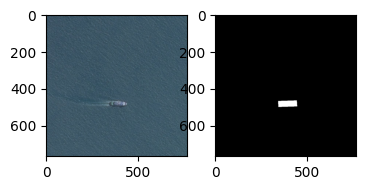

Dl example
[[-1.0904187  -1.1075435  -1.004795   ... -1.0561693  -1.1246682
  -1.0390445 ]
 [-1.1246682  -1.0561693  -0.9876702  ... -1.0390445  -1.1075435
  -1.1075435 ]
 [-1.2274168  -1.1760424  -1.0219197  ... -1.0904187  -1.141793
  -1.0732939 ]
 ...
 [-0.78217316 -0.8506722  -1.0561693  ... -1.0904187  -0.9876702
  -1.141793  ]
 [-0.8164227  -0.6965494  -0.86779696 ... -1.1075435  -1.0732939
  -0.90204644]
 [-1.1246682  -1.004795   -1.004795   ... -1.141793   -1.2274168
  -1.0219197 ]]


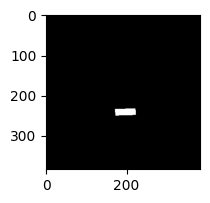

In [33]:
test_data_pipeline()

In [42]:
ckpt_path = WORK_DIR
ckpt_path = str(ckpt_path)
if USE_WANDB:
    wandb_logger = WandbLogger(project='satellite-segmentation',
                                log_model=True,
                                entity='viktor_povazhuk',
                                tags=['baseline', 'supervised', 'scratch'],
                                notes='Test run')
    wandb_logger.experiment.config.update(params)

early_stop_callback = EarlyStopping(monitor="val_dice", min_delta=1e-3, patience=4,
                                    verbose=True, mode="max", strict=True)
latest_checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="global_step",
    mode="max",
    dirpath=ckpt_path,
    filename="last",
)
best_checkpoint_callback = ModelCheckpoint(
    save_top_k=2,
    monitor="val_dice",
    mode="max",
    dirpath=ckpt_path,
    filename="{val_dice:.2f}",
)
trainer = pl.Trainer(max_epochs=params['epochs'], accelerator=params['device'].type,
                        devices=params['device_number'], logger=wandb_logger,
                        callbacks=[early_stop_callback, latest_checkpoint_callback, best_checkpoint_callback],
                        limit_train_batches=500, limit_val_batches=100, limit_test_batches=200)
if params['continue']:
    trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl, ckpt_path=str(MODELS_DIR / 'models/dice_0.82.ckpt'))
else:
    trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

trainer.test(model=model, dataloaders=test_dl)

if USE_WANDB:
    wandb.finish()

wandb: Currently logged in as: viktor_povazhuk. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 6.2500e-05.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5498663187026978     │
│         test_loss         │   0.0014506903244182467   │
└───────────────────────────┴───────────────────────────┘

# Evaluation

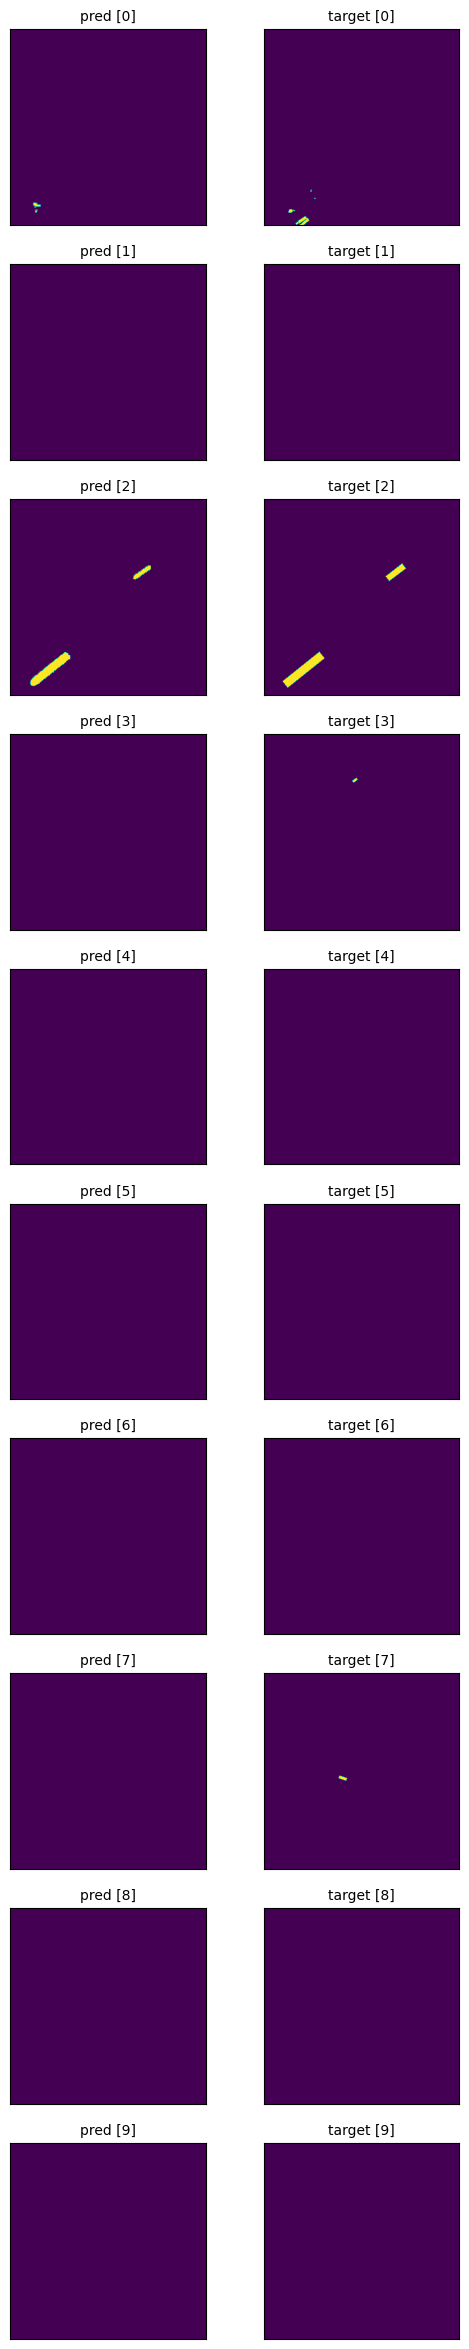

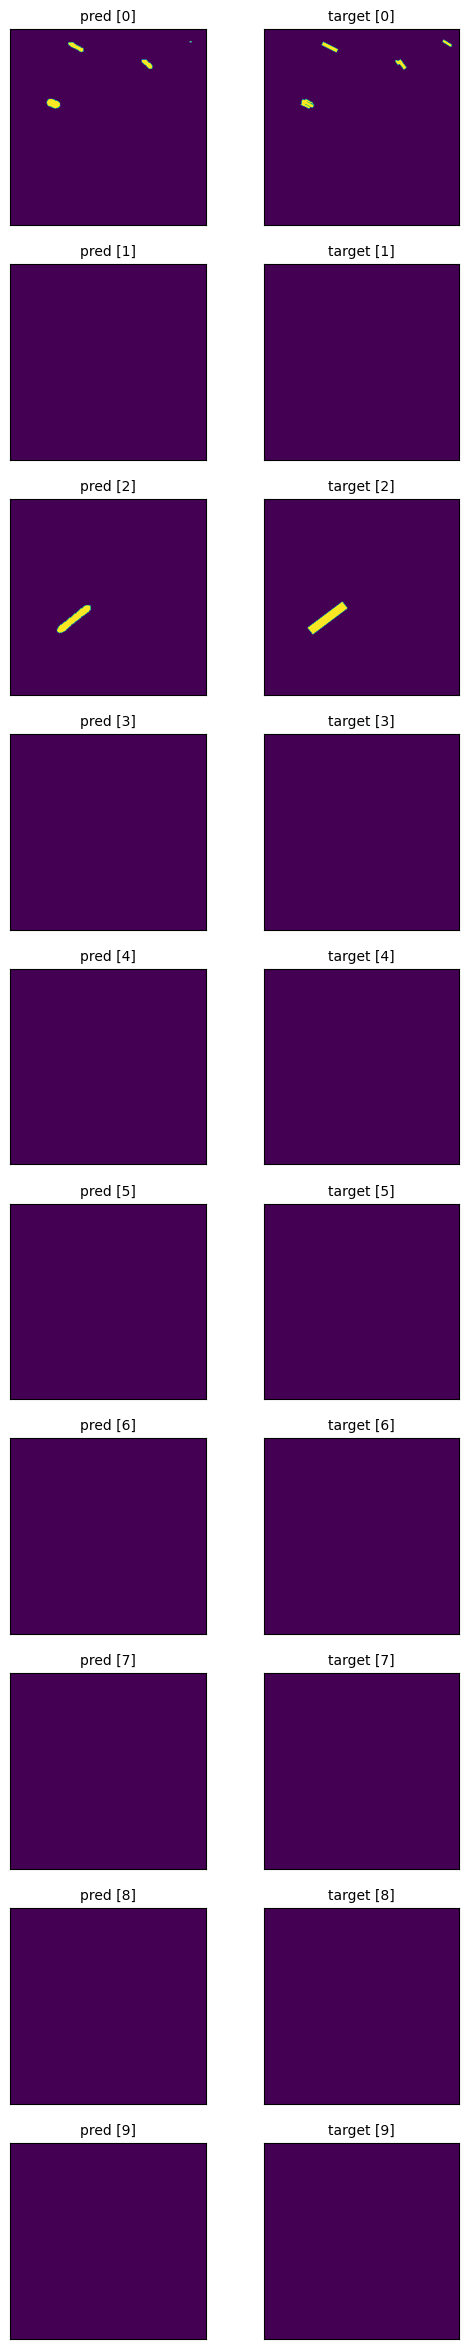

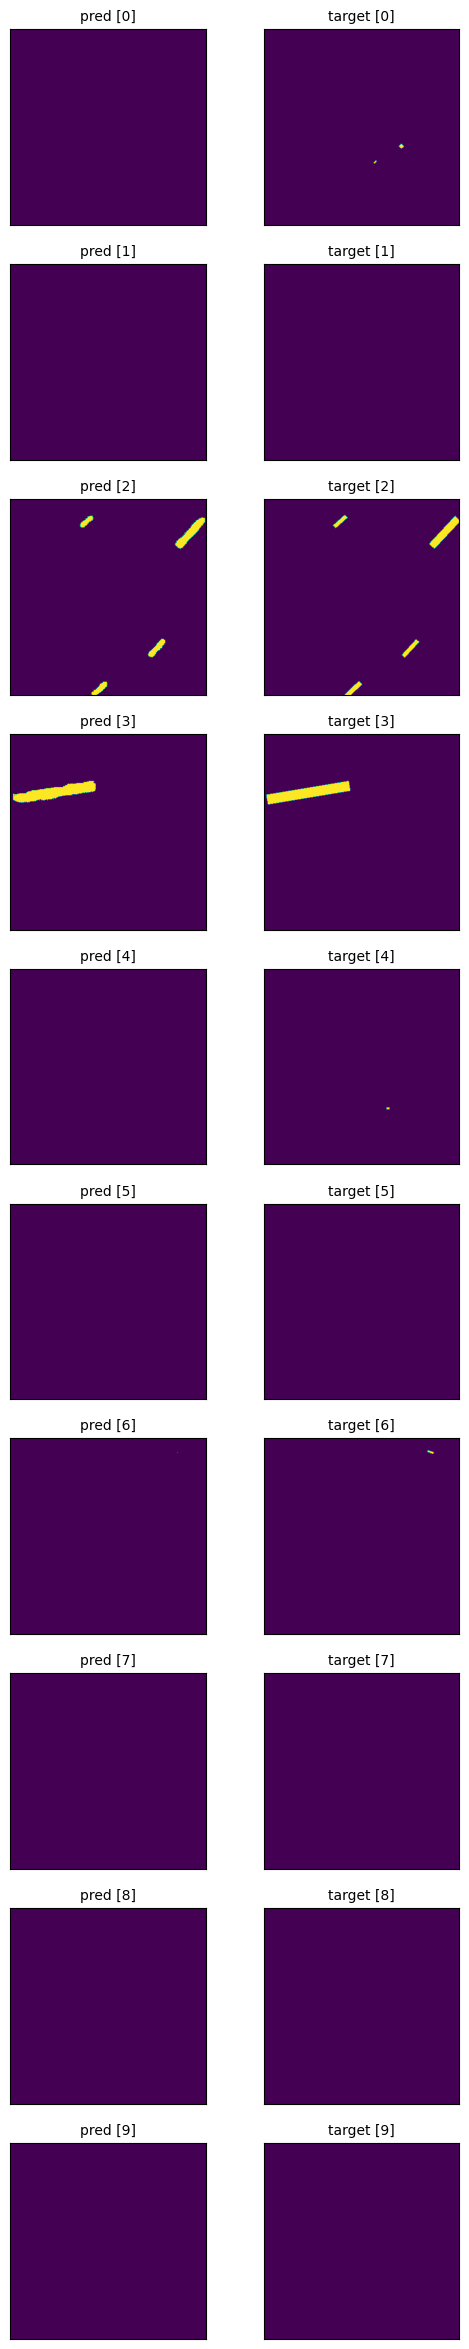

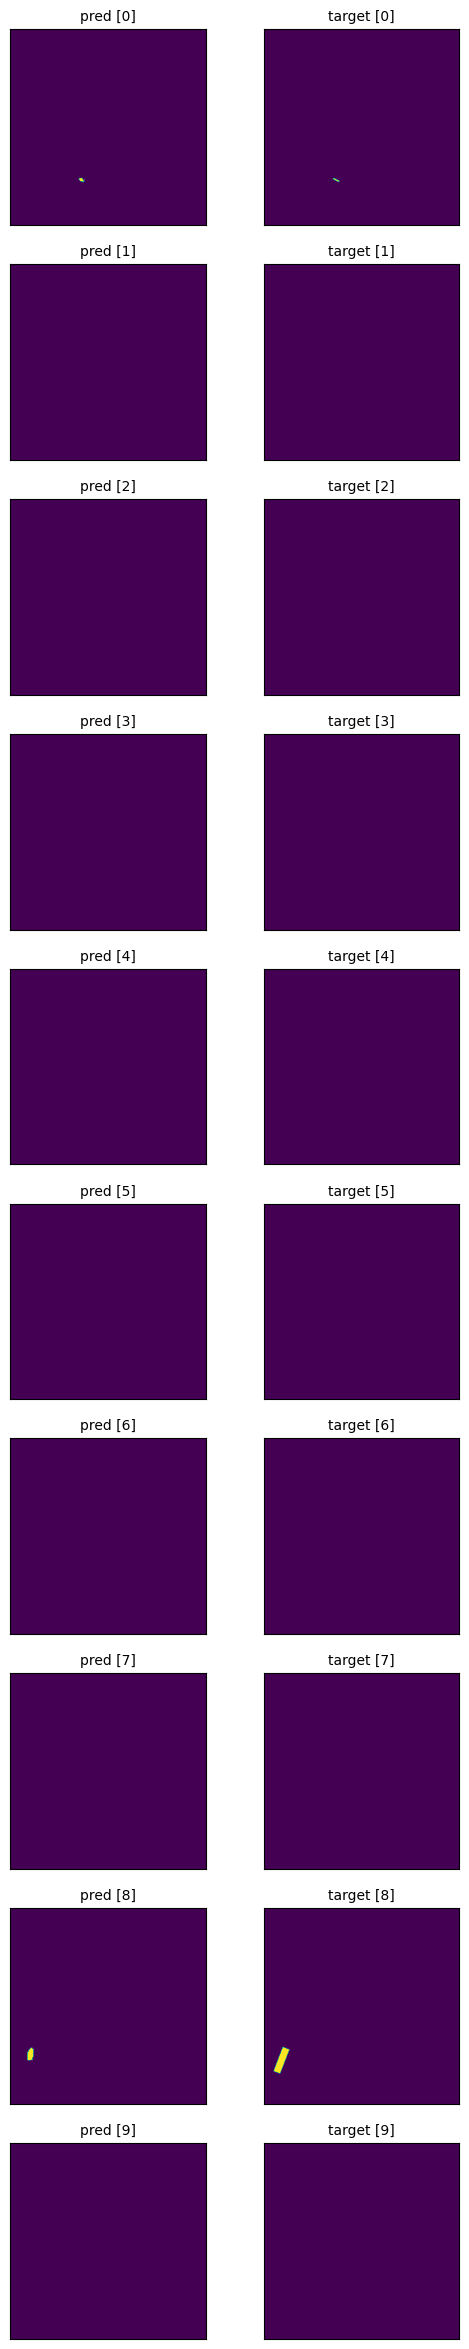

In [44]:
model.eval()

it = iter(test_dl)

for n in range(4):
    images, target = next(it)

    target = target.long()

    with torch.no_grad():
        output = model(images)

    pred = torch.max(output, 1)[1]

    target = target.numpy()
    pred = pred.numpy()

    fig = plt.figure(figsize=(6, 3*BATCH_SIZE))
    for i in range(BATCH_SIZE):
        ax = fig.add_subplot(BATCH_SIZE, 2, 2*i+1, xticks=[], yticks=[])
        ax.imshow(pred[i])
        ax.set_title(f'pred [{i}]', fontsize=10)
        ax = fig.add_subplot(BATCH_SIZE, 2, 2*i+2, xticks=[], yticks=[])
        ax.imshow(target[i])
        ax.set_title(f'target [{i}]', fontsize=10)
    plt.show()

In [42]:
768/32

24.0